In this notebook, we are attempting to use the player value we calculated, team, year, and position to predict the salary a player should make. Player value, as it encompasses the contribution a player makes towards their team, will have a heavy impact on how much a player should make, as discussed previously. In this model, however, we will also take team, year, and position into account. Small-market teams, such as Charlotte and New Orleans, pay less compared to big-market teams, such as Chicago and New York, for equally valued players. Likewise, positions are valued differently each year, so we will also take year into account. Finally, as previously analyzed, different positions have different player value vs salary distributions, so position needs to be accounted for in the model. With these variables, we will create a model to predict each player's value.

This model can be used for many purposes, such as predicting a player's salary in the future, or determining how salary's change based on different variables. 



In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

In [15]:
main_df = pd.read_csv("nba_data_master.csv")
df_2007 = main_df[(main_df["season_start"] >= 2007) & (main_df["season_start"] <= 2017)]
df_2007 = df_2007[df_2007["salary"] >= 1000000]
df_2007[">2014"] = (df_2007["season_start"] >= 2015)
salary_per_year = df_2007.groupby("season_start")["salary"].mean()
df_2007["average"] = df_2007["salary"] / np.mean(df_2007["season_start"])
df_2007.head()

,stage,team,player_key,league,salary,season,season_end,season_start,team.1,name,...,points_per_game,rebounds_per_game,assists_per_game,blocks_per_game,steals_per_game,turnovers_per_game,player_utility,player_value,>2014,average
1080,Playoffs,LAL,Kobe Bryant (2007 - 2008),NBA,19490625,2007 - 2008,2008,2007,Los Angeles Lakers,Kobe Bryant,...,30.142857,5.666667,5.571429,0.380952,1.666667,3.333333,46.061905,2.363285,False,9686.838033
1081,Playoffs,BOS,Kevin Garnett (2007 - 2008),NBA,23750000,2007 - 2008,2008,2007,Boston Celtics,Kevin Garnett,...,20.384615,10.538462,3.346154,1.115385,1.346154,2.115385,40.857692,1.720324,False,11803.746842
1082,Playoffs,BOS,Paul Pierce (2007 - 2008),NBA,16360094,2007 - 2008,2008,2007,Boston Celtics,Paul Pierce,...,19.653846,4.961538,4.576923,0.307692,1.076923,3.153846,32.088462,1.961386,False,8130.964542
1083,Playoffs,BOS,Ray Allen (2007 - 2008),NBA,16000000,2007 - 2008,2008,2007,Boston Celtics,Ray Allen,...,15.576923,3.769231,2.730769,0.307692,0.923077,1.461538,25.196154,1.574760,False,7951.997872
1084,Playoffs,SAS,Tony Parker (2007 - 2008),NBA,10500000,2007 - 2008,2008,2007,San Antonio Spurs,Tony Parker,...,22.411765,3.705882,6.058824,0.058824,0.941176,2.941176,35.005882,3.333894,False,5218.498604


C:\Users\chris\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


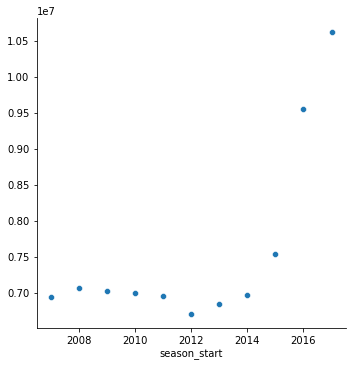

In [16]:

salary_per_year.head()
sns.relplot(salary_per_year.index, salary_per_year.values)

mse: 24450625452365.11
r^2 score: -0.8090615617611896


<AxesSubplot:xlabel='player_utility', ylabel='salary'>

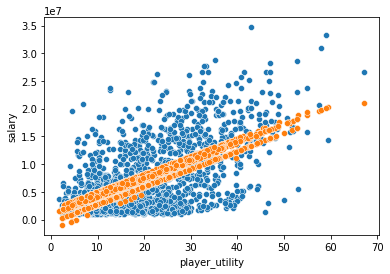

In [24]:
linear_model = LinearRegression()
data = df_2007[["player_utility"]].values
target = df_2007["salary"].values
categorical = OneHotEncoder().fit_transform(df_2007[["position"]].values).toarray()
data = np.append(data, categorical, axis=1)
linear_model.fit(X=data, y=target)
df_2007["predicted salary"] = linear_model.predict(data)
df_2007["salary difference"] = df_2007["salary"] - df_2007["predicted salary"]

mse = mean_squared_error(df_2007["predicted salary"], df_2007["salary"])
r2_score_value = r2_score(df_2007["predicted salary"], df_2007["salary"])
print("mse:", mse)
print("r^2 score:", r2_score_value)
df_2007.head()
sns.scatterplot(data=df_2007, x="player_utility", y="salary")
sns.scatterplot(data=df_2007, x="player_utility", y="predicted salary")




<AxesSubplot:xlabel='player_utility', ylabel='salary'>

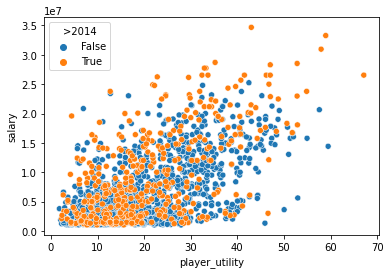

In [8]:
sns.scatterplot(data=df_2007, x="player_utility", y="salary", hue=">2014")

-0.726587737977662


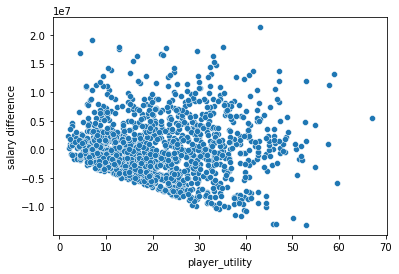

In [5]:
sns.scatterplot(data=df_2007, x="player_utility", y="salary difference")
poly_data = PolynomialFeatures(2, include_bias=False).fit_transform(data)
quadratic_model = LinearRegression()
quadratic_model.fit(X=poly_data, y=target)
mse = mean_squared_error(quadratic_model.predict(poly_data), df_2007["salary"])
r2_score_value = r2_score(quadratic_model.predict(poly_data), df_2007["salary"])
print(r2_score_value)

mse: 0.3801920629965128
r^2 score: -0.677418024163956


<AxesSubplot:xlabel='player_utility', ylabel='salary_normalized'>

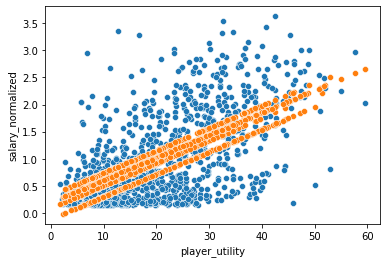

In [36]:
def mean(x):
    x["salary_normalized"] = x["salary"] / x["salary"].mean()
    return x
df_2007 = df_2007.groupby("season_start").apply(mean)
linear_model = LinearRegression()
data = df_2007[["player_utility"]].values
target = df_2007["salary_normalized"].values
categorical = OneHotEncoder().fit_transform(df_2007[["position"]].values).toarray()
data = np.append(data, categorical, axis=1)
linear_model.fit(X=data, y=target)
df_2007["predicted salary_normalized"] = linear_model.predict(data)
mse = mean_squared_error(df_2007["predicted salary_normalized"], df_2007["salary_normalized"])
r2_score_value = r2_score(df_2007["predicted salary_normalized"], df_2007["salary_normalized"])
print("mse:", mse)
print("r^2 score:", r2_score_value)
sns.scatterplot(data=df_2007, x="player_utility", y="salary_normalized")
sns.scatterplot(data=df_2007, x="player_utility", y="predicted salary_normalized")